Import Libraries and Packages

In [1]:
# import relevant packages
from utils import * # for project-specific custom functions
from policy import * # for policy functions
from plot_utils import * # for plotting functions

import os # for directories
import random
import math
from itertools import permutations

from pathlib import Path # path functions
from scipy.spatial.transform import Rotation as R # to convert between Euler angles and Quaternions
from IPython.display import clear_output, display

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

Setup directories, paths and variables

In [2]:
cwd = os.getcwd() # Current working directory
dataDir = Path(os.path.join(Path(cwd).parents[1], "Data\MultiTargetHerdingExperimentValidation")) #Directory of all sessions
colors = ['r', 'g', 'b']  #colors to plot the target agents in

firstTrial = 7
lastTrial = 25
numTrials = lastTrial - firstTrial
numTargets = 3

# set target first run (influenced) or contained as observed target order
targetOrderCriteria = 'run'  # 'run' or 'contain'

trialRange = range(firstTrial,lastTrial) ##[17, 18, 19, 20, 21, 22, 23, 24]#

In [3]:
columns = ["TrialID", "NumPlayerTrials",
           "ClosestDistanceFromHerder", "FurthestDistanceFromHerder", 
           "ClosestAngleFromHerder", "FurthestAngleFromHerder", 
           "ClosestFromContainmentZone", "FurthestFromContainmentZone", 
           "SuccessiveClosestDistanceFromHerder", "SuccessiveFurthestDistanceFromHerder",
           "SuccessiveClosestAngleFromHerder", "SuccessiveFurthestAngleFromHerder",
           "DynamicClosestDistanceFromHerder", "DynamicFurthestDistanceFromHerder",
           "DynamicClosestAngleFromHerder", "DynamicFurthestAngleFromHerder",
           "SuccessiveAngleCollinearity", "DynamicAngleCollinearity", "StaticAngleCollinearity",
           "StaticDistanceCollinearity", "SuccessiveDistanceCollinearity", "DynamicDistanceCollinearity",
           "Other"]

policyOrder = pd.DataFrame(columns = columns) 

targetPermutationList = list(permutations(range(1, numTargets+1)))
print(targetPermutationList)


[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]


Check All Trails for policy fit (NOT mutually exclusive)

In [4]:
tCount = 0
policyFrequency = pd.DataFrame(np.zeros((numTrials,len(columns))), columns = columns)
for trial in trialRange:
    trial_ID = "{:02}".format(trial)
    policyOrder["TrialID"] = trial_ID
    
    filePaths = [path for path in dataDir.rglob('*trialIdentifier'+trial_ID+'*')]
    initCondsData = pd.read_csv(filePaths[0]) # I say 0 but any will do as it's all based on init conds

    policyOrder["Other"] = [0,0,0]
    
    # define all non dynamic policies based on initial conditions
    tmp_order = get_closest_distance_from_herder_ordering(initCondsData) 
    policyOrder["ClosestDistanceFromHerder"] = tmp_order
    policyOrder["FurthestDistanceFromHerder"] = tmp_order[::-1]

    tmp_order = get_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["ClosestAngleFromHerder"] = tmp_order
    policyOrder["FurthestAngleFromHerder"] = tmp_order[::-1]

    tmp_order = get_closest_distance_from_zone_ordering(initCondsData)
    policyOrder["ClosestFromContainmentZone"] = tmp_order
    policyOrder["FurthestFromContainmentZone"] = tmp_order[::-1]

    policyOrder["SuccessiveClosestDistanceFromHerder"] = get_successive_closest_distance_from_herder_ordering(initCondsData)
    policyOrder["SuccessiveFurthestDistanceFromHerder"] = get_successive_furthest_distance_from_herder_ordering(initCondsData)
    
    policyOrder["SuccessiveClosestAngleFromHerder"] = get_successive_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["SuccessiveFurthestAngleFromHerder"] = get_successive_furthest_angle_from_herder_ordering(initCondsData)

    policyOrder["SuccessiveAngleCollinearity"] = get_successive_collinearity_ordering(initCondsData)
    policyOrder["StaticAngleCollinearity"] = get_static_collinearity_ordering(initCondsData)
    
    policyOrder["StaticDistanceCollinearity"] = get_distance_static_collinearity_ordering(initCondsData)
    policyOrder["SuccessiveDistanceCollinearity"] = get_distance_successive_collinearity_ordering(initCondsData)

    
    policyFrequency["TrialID"][tCount] = trial_ID
    policyFrequency["NumPlayerTrials"][tCount] = len(filePaths)
    policyFrequency["Other"][tCount] = 0;
    for filePath in filePaths:
        clear_output(wait=True)
        trialData = pd.read_csv(filePath)

        if (targetOrderCriteria == 'run'):
            # use first time herder influenced targets (i.e., run = true)
            observedTargetOrdering = np.argsort([np.where(trialData.t0run)[0][0], np.where(trialData.t1run)[0][0], np.where(trialData.t2run)[0][0]])
            print(trial_ID, " - Observed Target Order (run): ", observedTargetOrdering)
        else:
            # use first time herder contains a target (i.e., ct = true)
            try: 
                t0ct_idx = np.where(trialData.t0ct)[0][0]
            except:
                t0ct_idx = len(trialData.t0ct)

            try: 
                t1ct_idx = np.where(trialData.t1ct)[0][0]
            except:
                t1ct_idx = len(trialData.t1ct)

            try: 
                t2ct_idx = np.where(trialData.t2ct)[0][0]
            except:
                t2ct_idx = len(trialData.t2ct)
            
            observedTargetOrdering = np.argsort([t0ct_idx, t1ct_idx, t2ct_idx])
            print(trial_ID, " - Observed Target Order (contain): ", observedTargetOrdering)
            
        # Get all dynamic policies orderings
        policyOrder["DynamicClosestDistanceFromHerder"] = get_dynamic_closest_distance_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestDistanceFromHerder"] = get_dynamic_furthest_distance_from_herder_ordering(trialData)
    
        policyOrder["DynamicClosestAngleFromHerder"] = get_dynamic_closest_angle_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestAngleFromHerder"] = get_dynamic_furthest_angle_from_herder_ordering(trialData)
    
        policyOrder["DynamicAngleCollinearity"] = get_dynamic_collinearity_capturing_ordering(trialData)  
        
        policyOrder["DynamicDistanceCollinearity"] = get_dynamic_distance_collinearity_capturing_ordering(trialData)
        
        #heading_ordering = get_heading_capturing_ordering(trialData)
        #stochastic_collinearity_ordering = get_stochastic_collinearity_capturing_ordering(T)

        # Get frequnecy counts of policies
        for pol in columns[2:-1]:
            match = order_match(policyOrder[pol], observedTargetOrdering)
            if(match == 1):
                policyFrequency[pol][tCount] += match
            
    tCount = tCount + 1
#print(policyFrequency)
policyFrequency.to_csv('./Output/PolicyFrequency.csv')  

24  - Observed Target Order (run):  [1 0 2]


In [5]:
#print(policyFrequency)
# Get Policy Proportions For each Trial and Overall RankOrder Mean Proportions
#print(policyFrequency["NumPlayerTrials"].to_numpy(dtype=int))
policyFrequencyArray = policyFrequency.to_numpy(dtype=int)
policyFrequencyArray = policyFrequencyArray[:,2:]

#get overall mean and rankorder
N = np.sum(policyFrequency["NumPlayerTrials"].to_numpy(dtype=int))
PolicyRankOrder = pd.DataFrame({"Policy":columns[2:], "TotalCount":np.sum(policyFrequencyArray,axis=0) , "N":N , "MeanCount":np.mean(policyFrequencyArray,axis=0), 
                                "Proportion":np.sum(policyFrequencyArray,axis=0)/N})
PolicyRankOrder = PolicyRankOrder.sort_values(by="Proportion", ascending=False)
print("NOT MUTUALLY EXCLUSIVE")
display(PolicyRankOrder)
PolicyRankOrder.to_csv('./Output/PolicyRankOrder.csv')  

NOT MUTUALLY EXCLUSIVE


,Policy,TotalCount,N,MeanCount,Proportion
14,SuccessiveAngleCollinearity,129,180,7.166667,0.716667
8,SuccessiveClosestAngleFromHerder,118,180,6.555556,0.655556
18,SuccessiveDistanceCollinearity,89,180,4.944444,0.494444
12,DynamicClosestAngleFromHerder,83,180,4.611111,0.461111
15,DynamicAngleCollinearity,83,180,4.611111,0.461111
6,SuccessiveClosestDistanceFromHerder,76,180,4.222222,0.422222
16,StaticAngleCollinearity,76,180,4.222222,0.422222
5,FurthestFromContainmentZone,69,180,3.833333,0.383333
10,DynamicClosestDistanceFromHerder,62,180,3.444444,0.344444
19,DynamicDistanceCollinearity,60,180,3.333333,0.333333


In [6]:
# Get Mutualy Exclusive Policy Frequencies and Proportions
tCount = 0
targetPermutationOrderCount = np.zeros((numTrials,len(targetPermutationList)))
policyFrequencyMC = pd.DataFrame(np.zeros((numTrials,len(columns))), columns = columns)
for trial in trialRange:
    trial_ID = "{:02}".format(trial)
    policyOrder["TrialID"] = trial_ID
    
    filePaths = [path for path in dataDir.rglob('*trialIdentifier'+trial_ID+'*')]
    initCondsData = pd.read_csv(filePaths[0]) # I say 0 but any will do as it's all based in init conds

    policyOrder["Other"] = [0,0,0]
    # define all non dynamic policies based on initial conditions
    mp_order = get_closest_distance_from_herder_ordering(initCondsData) 
    policyOrder["ClosestDistanceFromHerder"] = tmp_order
    policyOrder["FurthestDistanceFromHerder"] = tmp_order[::-1]

    tmp_order = get_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["ClosestAngleFromHerder"] = tmp_order
    policyOrder["FurthestAngleFromHerder"] = tmp_order[::-1]

    tmp_order = get_closest_distance_from_zone_ordering(initCondsData)
    policyOrder["ClosestFromContainmentZone"] = tmp_order
    policyOrder["FurthestFromContainmentZone"] = tmp_order[::-1]

    policyOrder["SuccessiveClosestDistanceFromHerder"] = get_successive_closest_distance_from_herder_ordering(initCondsData)
    policyOrder["SuccessiveFurthestDistanceFromHerder"] = get_successive_furthest_distance_from_herder_ordering(initCondsData)
    
    policyOrder["SuccessiveClosestAngleFromHerder"] = get_successive_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["SuccessiveFurthestAngleFromHerder"] = get_successive_furthest_angle_from_herder_ordering(initCondsData)

    policyOrder["SuccessiveAngleCollinearity"] = get_successive_collinearity_ordering(initCondsData)
    policyOrder["StaticAngleCollinearity"] = get_static_collinearity_ordering(initCondsData)
    
    policyOrder["StaticDistanceCollinearity"] = get_distance_static_collinearity_ordering(initCondsData)
    policyOrder["SuccessiveDistanceCollinearity"] = get_distance_successive_collinearity_ordering(initCondsData)

    policyFrequencyMC["TrialID"][tCount] = trial_ID
    policyFrequencyMC["NumPlayerTrials"][tCount] = len(filePaths)
    
    for filePath in filePaths:
        clear_output(wait=True)
        trialData = pd.read_csv(filePath)

        if (targetOrderCriteria == 'run'):
            # use first time herder influenced targets (i.e., run = true)
            observedTargetOrdering = np.argsort([np.where(trialData.t0run)[0][0], np.where(trialData.t1run)[0][0], np.where(trialData.t2run)[0][0]])
            print(trial_ID, " - Observed Target Order (run): ", observedTargetOrdering)
        else:
            # use first time herder contains a target (i.e., ct = true)
            try: 
                t0ct_idx = np.where(trialData.t0ct)[0][0]
            except:
                t0ct_idx = len(trialData.t0ct)

            try: 
                t1ct_idx = np.where(trialData.t1ct)[0][0]
            except:
                t1ct_idx = len(trialData.t1ct)

            try: 
                t2ct_idx = np.where(trialData.t2ct)[0][0]
            except:
                t2ct_idx = len(trialData.t2ct)
            
            observedTargetOrdering = np.argsort([t0ct_idx, t1ct_idx, t2ct_idx])
            print(trial_ID, " - Observed Target Order (contain): ", observedTargetOrdering)
            
        # Get all dynamic policies orderings
        policyOrder["DynamicClosestDistanceFromHerder"] = get_dynamic_closest_distance_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestDistanceFromHerder"] = get_dynamic_furthest_distance_from_herder_ordering(trialData)
    
        policyOrder["DynamicClosestAngleFromHerder"] = get_dynamic_closest_angle_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestAngleFromHerder"] = get_dynamic_furthest_angle_from_herder_ordering(trialData)
    
        policyOrder["DynamicAngleCollinearity"] = get_dynamic_collinearity_capturing_ordering(trialData)  
        
        policyOrder["DynamicDistanceCollinearity"] = get_dynamic_distance_collinearity_capturing_ordering(trialData)
        #heading_ordering = get_heading_capturing_ordering(trialData)
        #stochastic_collinearity_ordering = get_stochastic_collinearity_capturing_ordering(T)

        for pC in range(len(targetPermutationList)):
            torder = np.array(targetPermutationList[pC], dtype=int)-1
            match = order_match(torder, observedTargetOrdering)
            if(match == 1):
                targetPermutationOrderCount[tCount,pC] += 1
                break

        # Get mutually exclusive frequnecy counts of policies
        for pol in PolicyRankOrder["Policy"]:
            match = order_match(policyOrder[pol], observedTargetOrdering)
            if(match == 1):
                policyFrequencyMC[pol][tCount] += match
                break
        
        if(match == 0):
            policyFrequencyMC["Other"][tCount] += 1
            
    tCount = tCount + 1
policyFrequencyMC.to_csv('./Output/PolicyFrequency_MutExc.csv')  

24  - Observed Target Order (run):  [1 0 2]


In [7]:
# Get Policy Proportions For each Trial and Overall RankOrder Mean Proportions
#print(policyFrequencyMC["NumPlayerTrials"].to_numpy(dtype=int))
policyFrequencyArrayMC = policyFrequencyMC.to_numpy(dtype=int)
policyFrequencyArrayMC = policyFrequencyArrayMC[:,2:]

#get overall mean and rankorder
N = np.sum(policyFrequencyArrayMC)
PolicyRankOrderMC = pd.DataFrame({"Policy":columns[2:], "TotalCount":np.sum(policyFrequencyArrayMC,axis=0) , "N":N , "MeanCount":np.mean(policyFrequencyArrayMC,axis=0), 
                                "Proportion":np.sum(policyFrequencyArrayMC,axis=0)/N})
PolicyRankOrderMC = PolicyRankOrderMC.sort_values(by="Proportion", ascending=False)
print("MUTUALLY EXCLUSIVE")
display(PolicyRankOrderMC)
PolicyRankOrderMC.to_csv('./Output/PolicyRankOrder_MutExc.csv')  

MUTUALLY EXCLUSIVE


,Policy,TotalCount,N,MeanCount,Proportion
14,SuccessiveAngleCollinearity,129,180,7.166667,0.716667
18,SuccessiveDistanceCollinearity,13,180,0.722222,0.072222
20,Other,12,180,0.666667,0.066667
5,FurthestFromContainmentZone,6,180,0.333333,0.033333
12,DynamicClosestAngleFromHerder,5,180,0.277778,0.027778
4,ClosestFromContainmentZone,4,180,0.222222,0.022222
16,StaticAngleCollinearity,3,180,0.166667,0.016667
0,ClosestDistanceFromHerder,3,180,0.166667,0.016667
1,FurthestDistanceFromHerder,2,180,0.111111,0.011111
7,SuccessiveFurthestDistanceFromHerder,2,180,0.111111,0.011111


C:\Users\MQ20208365\AppData\Local\Temp\ipykernel_11832\3506560620.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


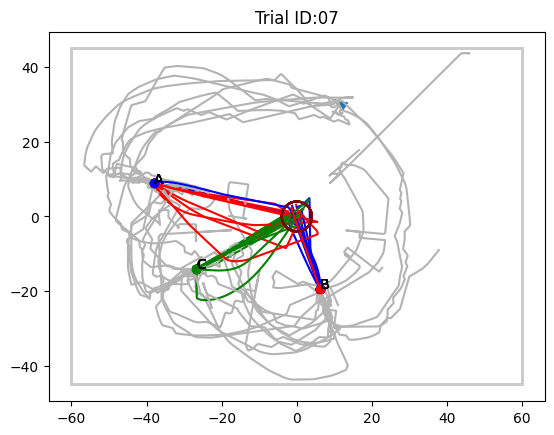

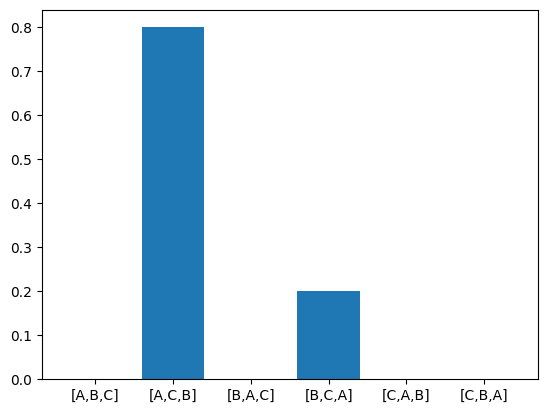

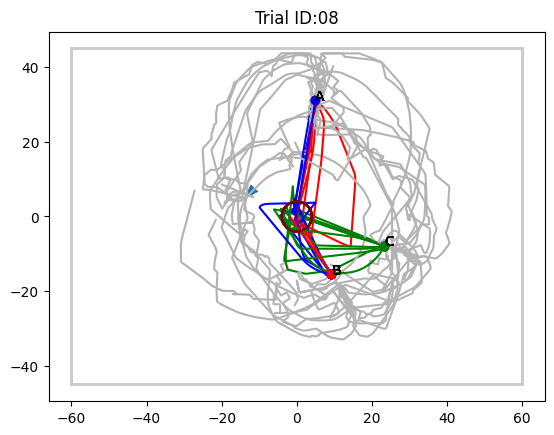

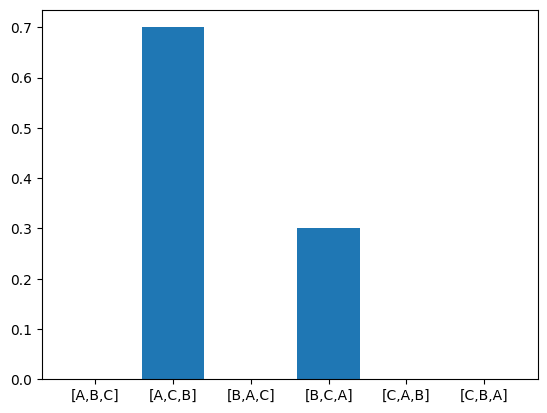

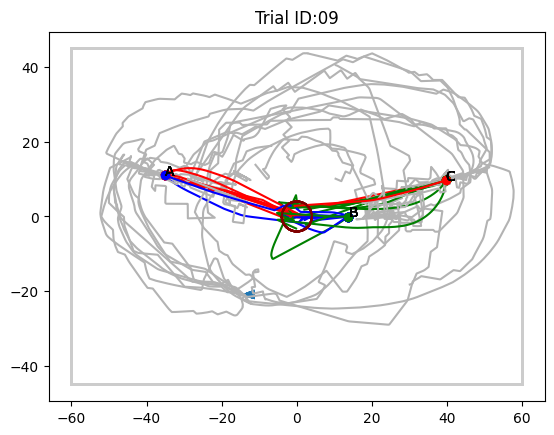

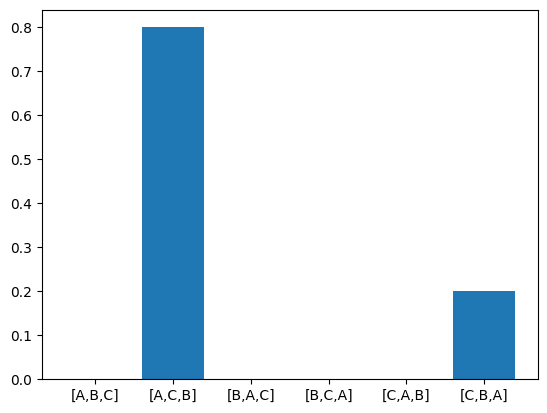

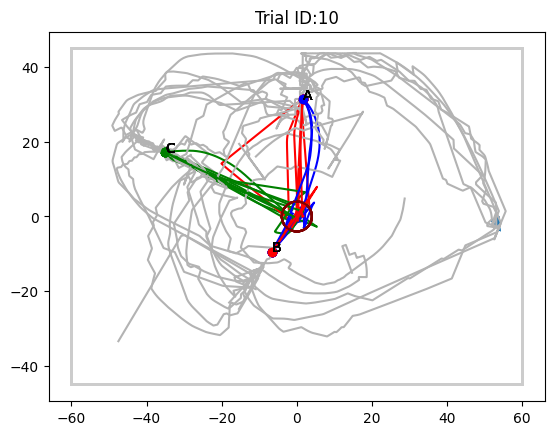

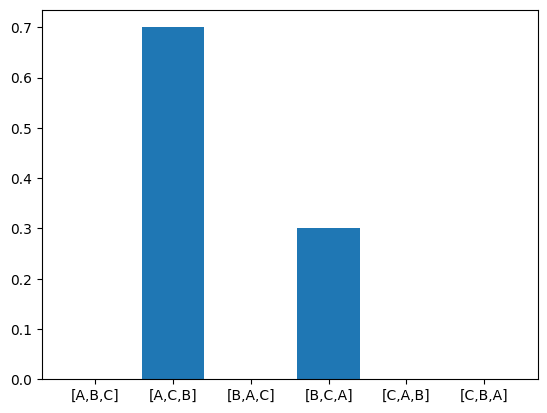

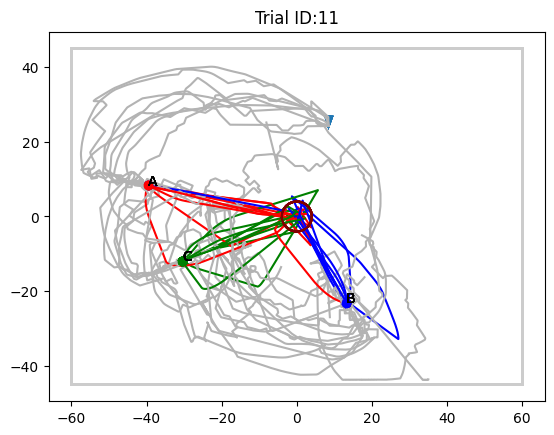

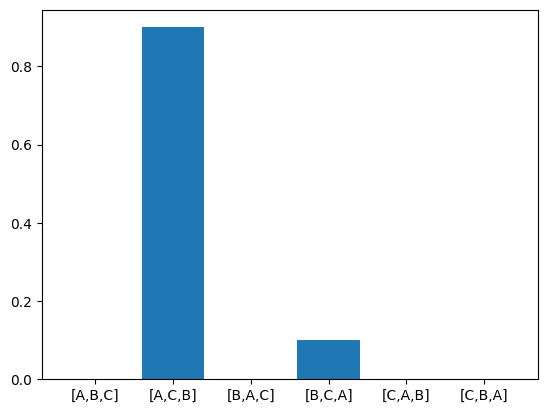

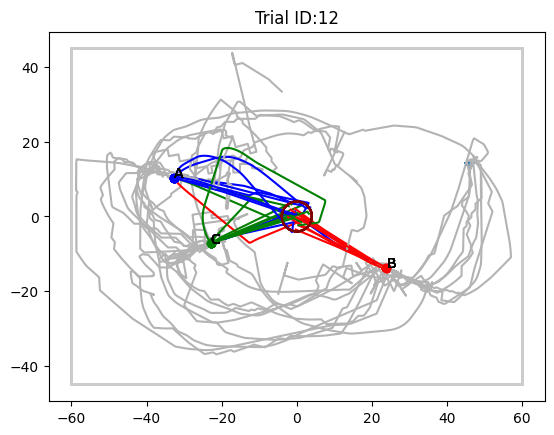

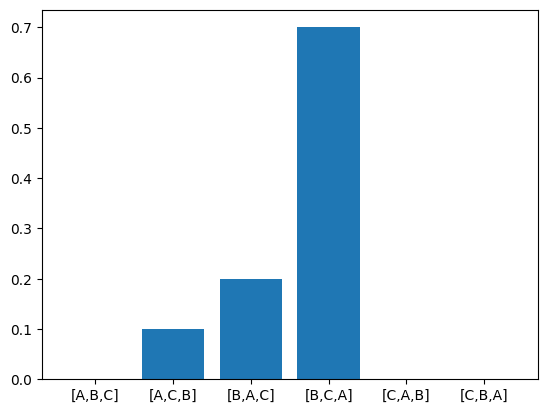

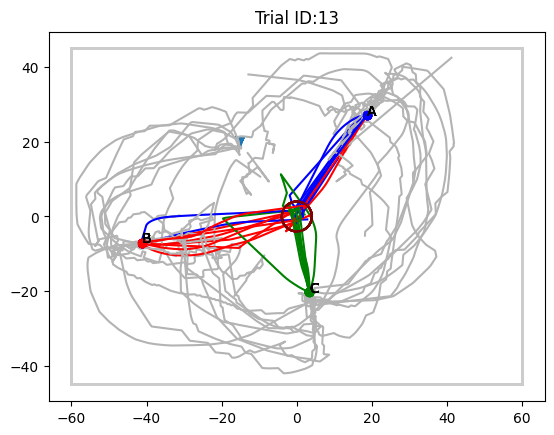

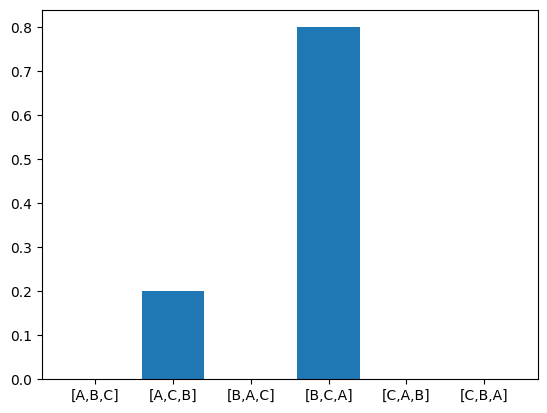

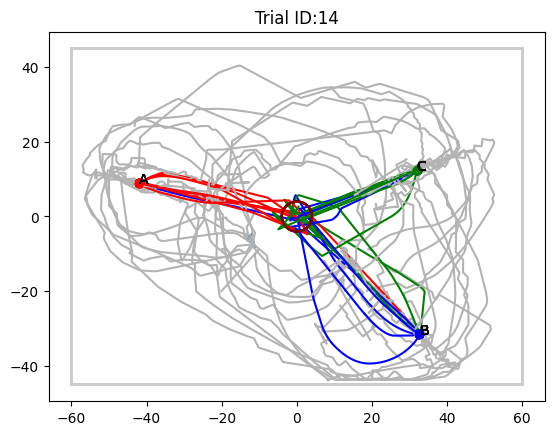

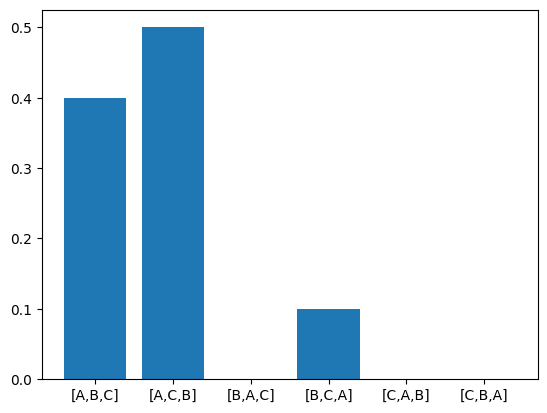

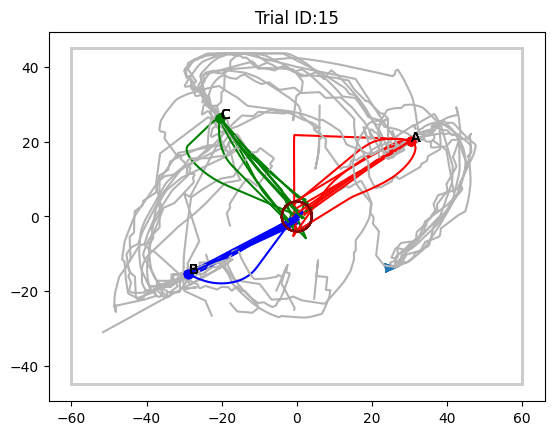

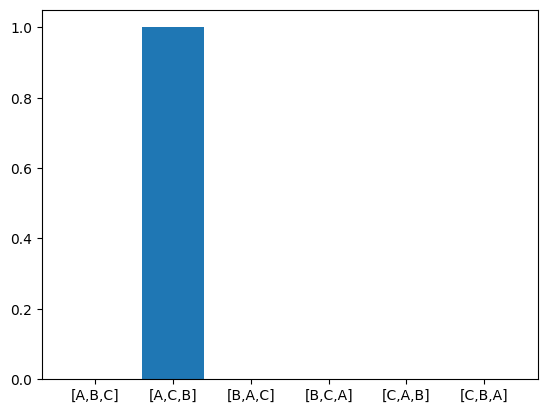

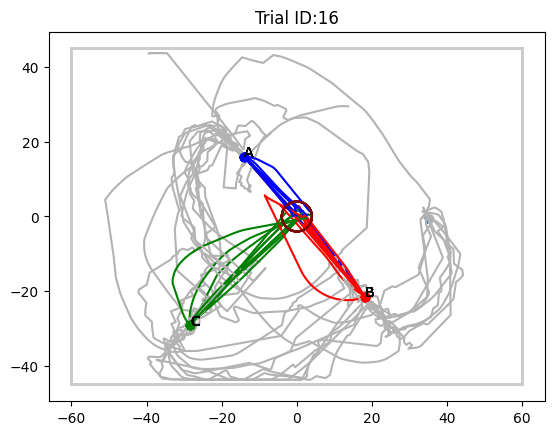

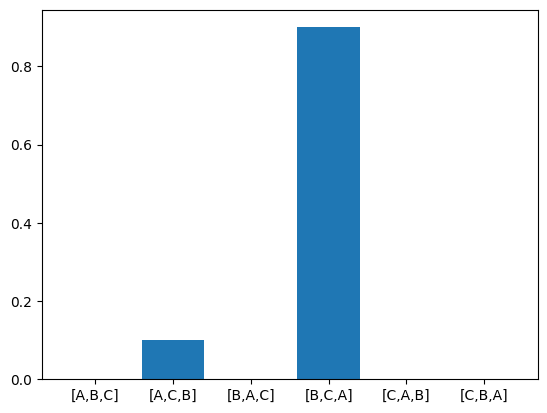

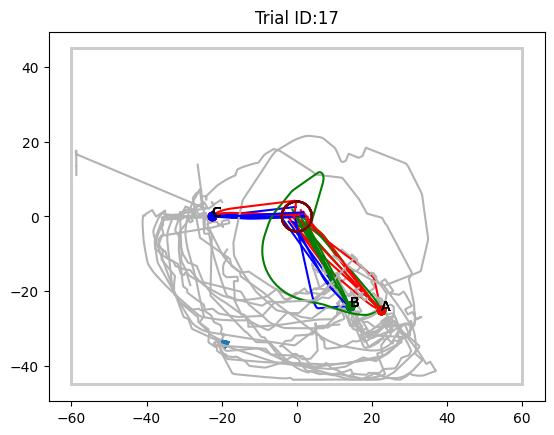

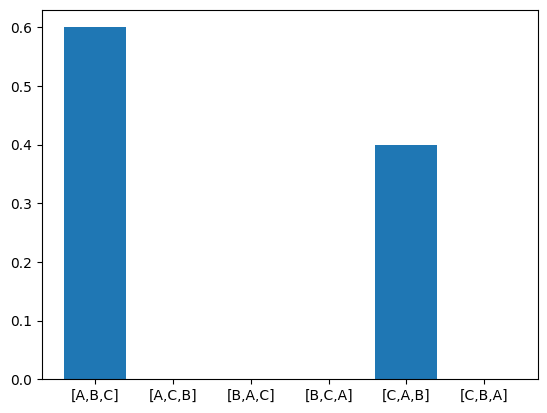

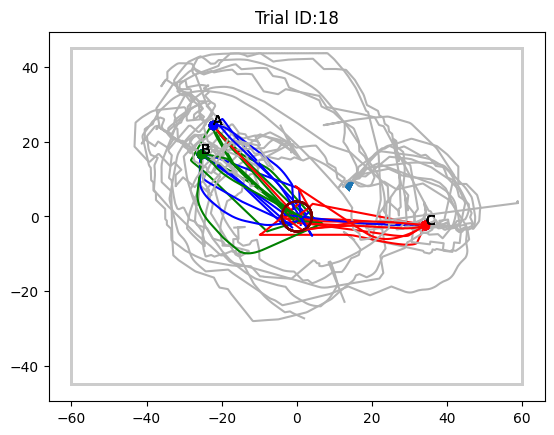

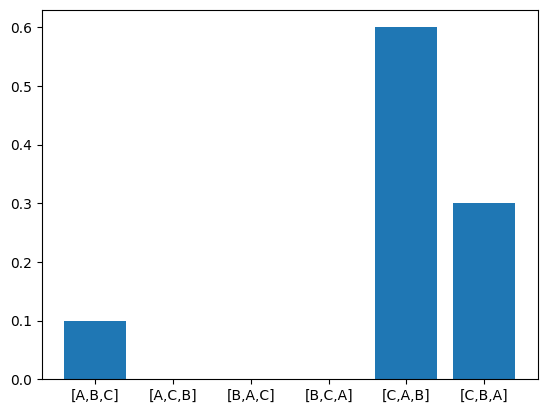

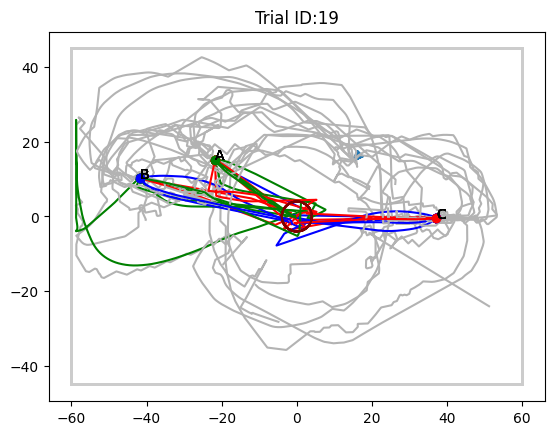

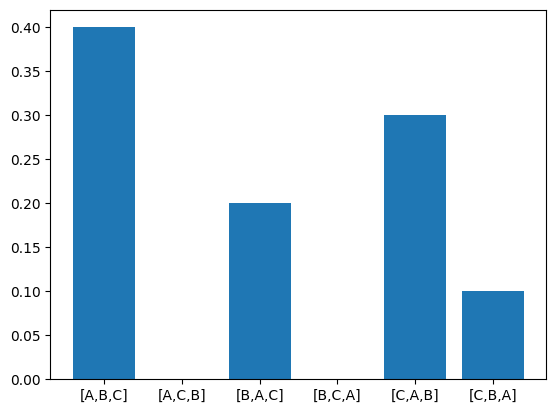

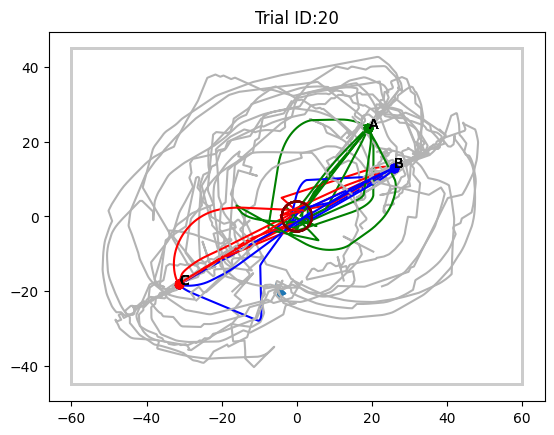

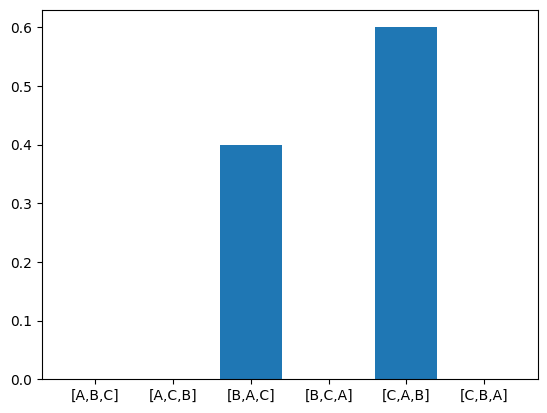

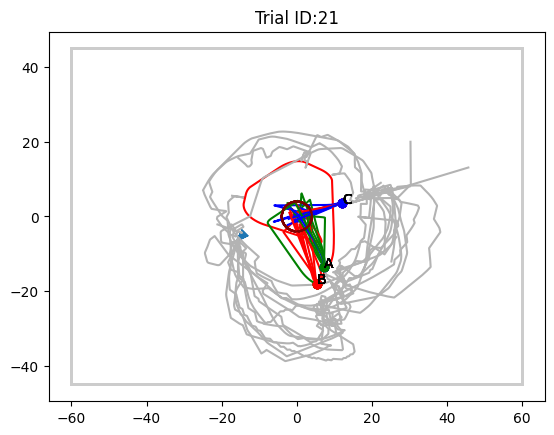

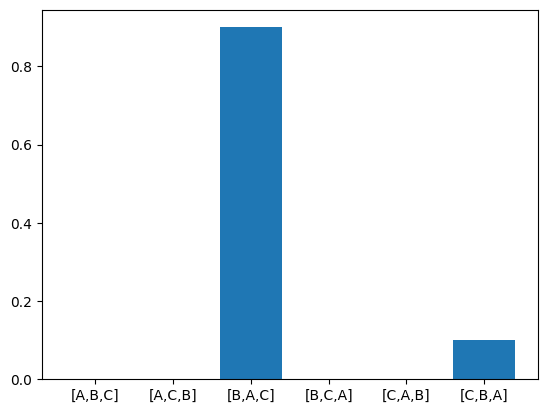

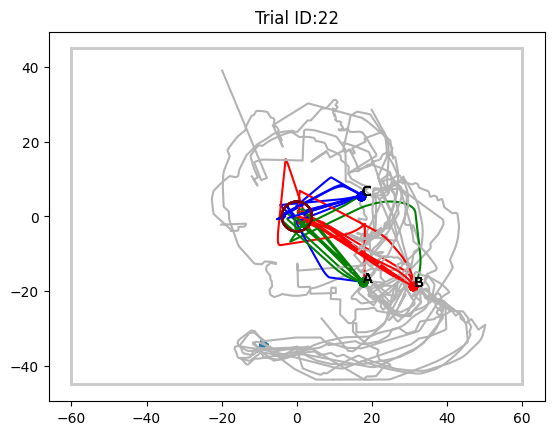

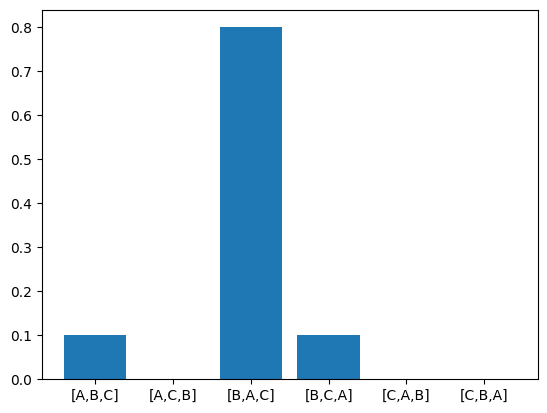

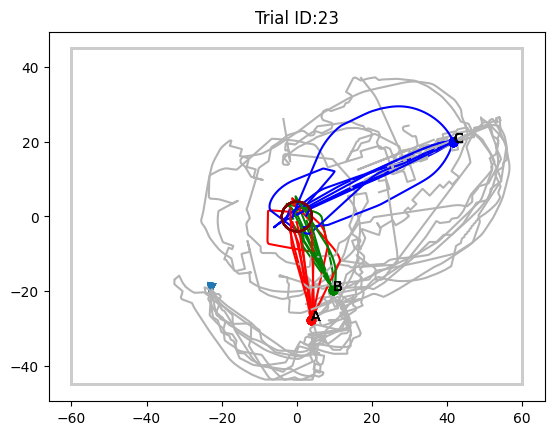

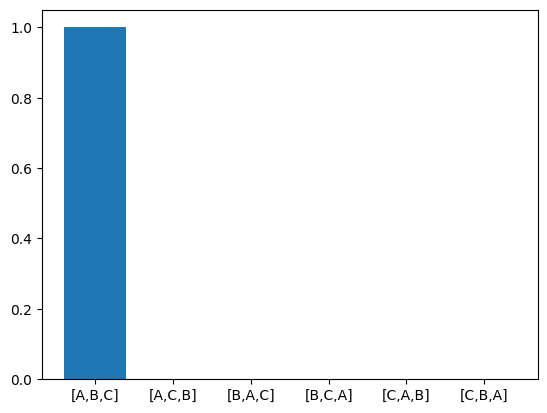

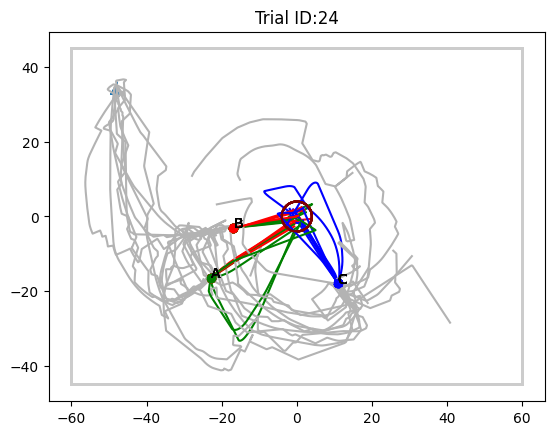

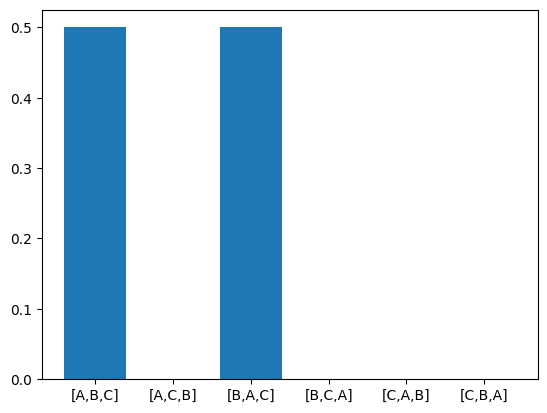

<Figure size 640x480 with 0 Axes>

In [8]:
# Do Trajectory PLots
tCount = 0
for trial in trialRange:
    trial_ID = "{:02}".format(trial)
    
    filePaths = [path for path in dataDir.rglob('*trialIdentifier'+trial_ID+'*')]
    initCondsData = pd.read_csv(filePaths[0]) # I say 0 but any will do as it's all based in init conds

    for filePath in filePaths:
        trialData = pd.read_csv(filePath)
        observedTargetOrdering = np.argsort([np.where(trialData.t0run)[0][0], np.where(trialData.t1run)[0][0], np.where(trialData.t2run)[0][0]])
        plotter(trialData, observedTargetOrdering, colors)
    
    #plt.title("Trial ID:"+trial_ID+", Max score is "+Keymax+" score: "+str(trial_specific_score[Keymax]))
    plt.title("Trial ID:"+trial_ID)
    plt.figure()

    x_labels = ["[A,B,C]", "[A,C,B]", "[B,A,C]", "[B,C,A]", "[C,A,B]", "[C,B,A]"]
    values = targetPermutationOrderCount[tCount,:] / 10
    
    plt.bar([1,2,3,4,5,6], values)
    plt.xticks([1,2,3,4,5,6],x_labels)
    plt.figure()

    tCount = tCount + 1

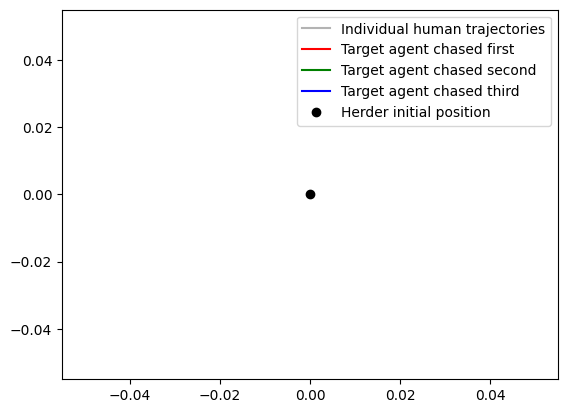

In [9]:
plt.plot(0,0, c=[.7, .7, .7], label = "Individual human trajectories")
plt.plot(0,0,'r', label = "Target agent chased first")
plt.plot(0,0,'g', label = "Target agent chased second")
plt.plot(0,0,'b', label = "Target agent chased third")
plt.plot(0,0,'ko', label = "Herder initial position")

plt.legend()